# Fraud Detection Model 

## Requirements 

- Use data science & ML to detect fraud in financial transactions
- Train models using historical transaction data
- Perform real-time detection via streaming with Apache Kafka
- Display flagged transactions in a live dashboard, showing reasons for flagging & fraud probability

## In this project 
We will be using data from the Credit Card Fraud dataset: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data to determine & train the best model for credit card detection 

To do this we will be measuring multiple models against several measurement methods i.e. Precision, Accuracy to determine how reliable the model is

### Data Description

#### 1.0 Loading the Data

In [81]:
from imblearn.over_sampling import SMOTE
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss
import numpy as np

# Load the dataset
df = pd.read_csv('../data/Variant I.csv')
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.560867,4.946516e-01,16.960120,83.585392,31.974200,1.051720e+00,8.715090,1574.468789,5661.914760,4767.082829,4857.207209,181.172099,9.862556,129.414278,0.531315,0.399768,0.898214,10.799300,0.218157,507.156910,0.025010,7.464706,0.579841,1.016889,0.0,3.288668
std,0.104438,0.290389,2.888474e-01,43.870653,86.458280,10.897167,5.462110e+00,20.210541,1003.700453,3010.869604,1481.613486,919.760516,457.642671,5.003306,69.072421,0.499019,0.489851,0.302367,12.121409,0.412995,481.460578,0.156155,7.948670,0.493584,0.175465,0.0,2.209990
min,0.000000,0.100000,5.024707e-08,-1.000000,-1.000000,10.000000,1.373749e-08,-15.739893,1.000000,-174.109691,1322.325176,2855.161883,0.000000,0.000000,-191.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,2.268462e-01,-1.000000,18.000000,20.000000,7.150757e-03,-1.180401,893.000000,3431.170414,3587.024902,4269.207278,1.000000,6.000000,82.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.092919,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,4.922199e-01,-1.000000,50.000000,30.000000,1.510390e-02,-0.828224,1270.000000,5299.991908,4745.547722,4913.792545,9.000000,9.000000,121.000000,1.000000,0.000000,1.000000,5.000000,0.000000,200.000000,0.000000,5.081925,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,7.558383e-01,15.000000,124.000000,40.000000,2.618513e-02,6.215877,1952.000000,7692.312342,5753.146673,5488.559005,24.000000,13.000000,176.000000,1.000000,1.000000,1.000000,25.000000,0.000000,500.000000,0.000000,8.758878,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,1.000000e+00,399.000000,429.000000,90.000000,7.663502e+01,113.120051,6678.000000,16817.838935,9539.356530,7019.201030,2386.000000,39.000000,388.000000,1.000000,1.000000,1.000000,32.000000,1.000000,2100.000000,1.000000,85.567848,1.000000,2.000000,0.0,7.000000


In [82]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.9,0.990415,11,4,40,0.014640,-0.897718,AC,1853,6711.523027,4868.779488,4988.827961,0,19,CA,113,1,BC,0,1,-1,0,200.0,0,INTERNET,6.150317,windows,0,1,0,0
1,0,0.4,0.781728,-1,151,30,0.013269,11.501507,AA,5447,8948.772349,5824.765506,6451.180606,16,14,CA,83,1,BB,0,1,5,0,1500.0,0,INTERNET,4.521952,windows,1,1,0,0
2,0,0.7,0.274290,-1,92,20,0.010669,23.943928,AA,2312,11727.292100,7679.867045,6731.304261,1351,15,CA,70,0,BC,1,1,28,0,200.0,0,INTERNET,8.361707,other,1,1,0,0
3,0,0.9,0.722684,-1,55,20,0.021849,48.202774,AA,2413,4126.145203,4458.366351,6356.833258,30,8,CA,222,1,BD,1,1,20,0,1500.0,0,INTERNET,7.339743,other,0,1,0,0
4,0,0.9,0.121661,-1,51,20,0.021491,-1.602116,AB,1227,9730.276231,5544.081678,6721.196241,505,12,CA,126,1,BE,0,1,1,0,1500.0,0,INTERNET,4.338063,other,0,1,0,0


In [83]:
df.tail()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
999995,0,0.9,0.173671,-1,110,30,0.004057,-1.451974,AB,979,1290.193422,3509.677630,3696.222287,6,5,CB,217,1,BB,1,1,25,0,200.0,0,INTERNET,5.740367,other,1,1,0,7
999996,0,0.9,0.566285,-1,29,50,0.014215,-0.672890,AB,1190,1244.988645,2476.158833,3136.372338,14,3,CE,212,0,BC,0,1,1,0,200.0,0,INTERNET,26.319296,linux,0,1,0,7
999997,0,0.6,0.807476,-1,164,30,0.040160,46.129201,AA,1571,4452.976672,3441.533927,3009.209161,16,4,CA,185,0,BC,1,1,25,0,1000.0,0,INTERNET,1.614444,linux,1,1,0,7
999998,0,0.8,0.151376,87,12,30,0.016871,-1.212084,AC,1435,2989.280984,2846.053283,3004.093680,1,10,CF,142,0,BC,1,1,-1,0,200.0,0,INTERNET,3.682591,linux,0,1,0,7
999999,0,0.8,0.145820,63,4,30,0.026896,-0.506524,AB,629,4572.951587,1911.967174,3159.574357,3,5,CA,110,1,BB,0,1,1,0,200.0,0,INTERNET,15.761976,linux,0,1,0,7


#### 1.1 Data columns

- **fraud_bool:** Whether the transaction was fraudulent or not
- **income:** Income of applicant in percentiles [0-1]
- **name_email_similarity:** Similarity between applicant name and email 
- **prev_address_months_count:**: Months in currently registered address of the applicant. Ranges between [−1, 406] months (-1 is a missing value).
- **customer_age:**: Age of customer
- **days_since_request**: Number of days passed since application was done 
- **intended_balcon_amount:** Amount user intends to borrow/spend
- **payment_type:** Credit payment plan 
- **zip_count_4w**: Number of applications within same zip code in last 4 weeks
- **velocity_6h, velocity_24h, velocity_4**: Number of transactions (or volume) in last 6 hours, 24 hours, and 4 weeks respectively
- **has_other_cards:** Whether the applicant has any other cards {0: no, 1: yes}
- **bank_branch_count_8w:** Number of total applications in the selected bank branch in the last 8 weeks
- **date_of_birth_distinct_emails_4w:** Number of emails for applicants with the same date of birth in last 4 weeks
- **employment_status:** Employment status of the applicant
- **credit_risk_score:** Internal score of application risk 
- **email_is_free:** Domain of application email (free or paid)
- **housing_status:** Current residential status for applicant
- **phone_home_valid:** Validity of provided home phone
- **phone_mobile_valid:** Validity of provided mobile phone
- **bank_months_count:** How old is the previous account in months (-1 is a missing value)
- **proposed_credit_limit:** Applicant's proposed credit limit 
- **foreign_request:** If origin country of request is different from banks' country 
- **source:** Online source of application 
- **session_length_in_minutes:** Length of user session in banking website in minutes 
- **device_os:** Operative system of device that made request
- **keep_alive_session:** User option on session logout 
- **device_distinct_emails_8w:** Number of distinct emails in banking website from the used device in the last 8 weeks 
- **device_fraud_count:** Number of fradulent applications with used device 
- **month:** Month where the application was made

#### 1.2 Removing NaN values 

In [84]:
df.isna().mean()

fraud_bool                          0.0
income                              0.0
name_email_similarity               0.0
prev_address_months_count           0.0
current_address_months_count        0.0
customer_age                        0.0
days_since_request                  0.0
intended_balcon_amount              0.0
payment_type                        0.0
zip_count_4w                        0.0
velocity_6h                         0.0
velocity_24h                        0.0
velocity_4w                         0.0
bank_branch_count_8w                0.0
date_of_birth_distinct_emails_4w    0.0
employment_status                   0.0
credit_risk_score                   0.0
email_is_free                       0.0
housing_status                      0.0
phone_home_valid                    0.0
phone_mobile_valid                  0.0
bank_months_count                   0.0
has_other_cards                     0.0
proposed_credit_limit               0.0
foreign_request                     0.0


Whilst there are no NaN values in the dataset, certain columns have in place -1 to represent missing values. Before determining how to deal with these, lets see the distribution of missing values for each class

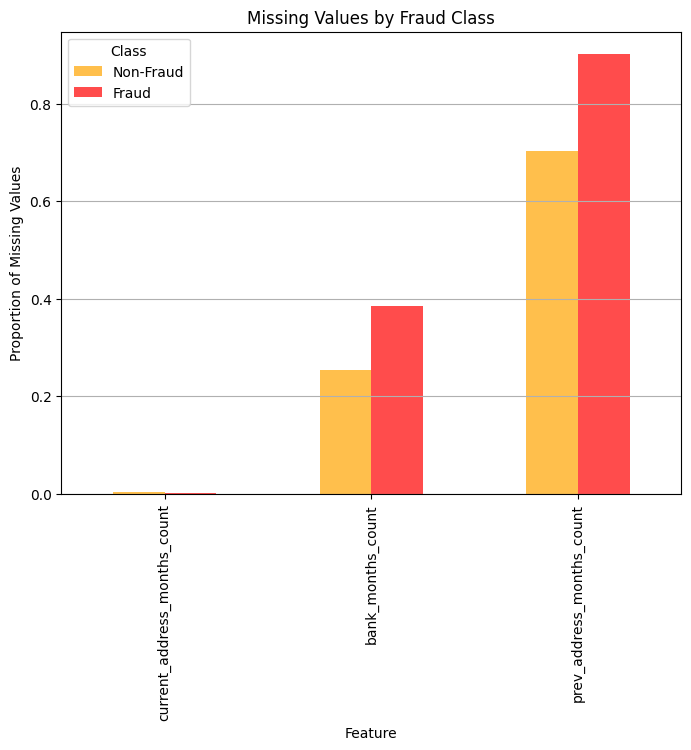

In [85]:
missing_features = ['current_address_months_count', 'bank_months_count', 'prev_address_months_count']

missing_by_fraud = {}
for col in missing_features:
    missing_by_fraud[col] = df.groupby('fraud_bool')[col].apply(lambda x: (x == -1).mean())

# Convert to DataFrame and transpose for plotting
missing_df = pd.DataFrame(missing_by_fraud).T
missing_df.columns = ['Non-Fraud', 'Fraud']  # 0: Non-Fraud, 1: Fraud

missing_df.plot(kind='bar', figsize=(8,6), color=['orange', 'red'], alpha=0.7)
plt.legend(title='Class')
plt.title('Missing Values by Fraud Class')
plt.xlabel('Feature')
plt.ylabel('Proportion of Missing Values')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

A fraud transaction is much more likely to have the amount of time they've been at the bank & the prev_address_months_count empty which insinuates that they are creating new/temporary bank accounts for the purpose of scamming. This is something we will consider in the model thus dropping these rows would reduce the training effectiveness. Instead, we will replace them with NaN. 

In [86]:
df[missing_features] = df[missing_features].replace(-1, np.nan)

In [87]:
df.info()  # Display dataset statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         295633 non-null   float64
 4   current_address_months_count      995558 non-null   float64
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

#### 1.3 Data Description 

In [88]:
num_attributes = df.select_dtypes(exclude='object')
cat_attributes = df.select_dtypes(include='object')

fraud = df[df['fraud_bool'] == 1]
non_fraud = df[df['fraud_bool'] == 0]

##### Numerical attributes

To analyse the dataset with more clarity, we split the attributes into numerical and categorical. We will also engineer our own statistical measures to give us a better insight 

- **coefficient-variance:** Measure that expresses the extent of the variability of dispersion of a data set relative to its mean 
- **range:** Measures the range of data from its maximum to its minimum 
- **skewness:** Measures assymetry of the probability distribution of a random variable about its mean (positive, negative, or undefined)
- **kurtosis:** Measures tailedness of a distribution - how often outliers occur

In [89]:
describe = num_attributes.describe().T
describe['range'] = describe['max'] - describe['min']
describe['variance coef'] = (describe['std'] / describe['mean']).round(2)
describe['kurtosis'] = num_attributes.kurtosis().round(2)
describe

,count,mean,std,min,25%,50%,75%,max,range,variance coef,kurtosis
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,9.47,85.68
income,1000000.0,0.560867,0.290389,1.000000e-01,0.300000,0.600000,0.800000,0.900000,0.800000,0.52,-1.31
name_email_similarity,1000000.0,0.494652,0.288847,5.024707e-08,0.226846,0.492220,0.755838,1.000000,1.000000,0.58,-1.28
prev_address_months_count,295633.0,59.751405,62.534715,6.000000e+00,25.000000,34.000000,65.000000,399.000000,393.000000,1.05,6.18
current_address_months_count,995558.0,83.962797,86.465722,0.000000e+00,19.000000,51.000000,124.000000,429.000000,429.000000,1.03,1.56
customer_age,1000000.0,31.974200,10.897167,1.000000e+01,20.000000,30.000000,40.000000,90.000000,80.000000,0.34,0.26
days_since_request,1000000.0,1.051720,5.462110,1.373749e-08,0.007151,0.015104,0.026185,76.635022,76.635022,5.19,103.16
intended_balcon_amount,1000000.0,8.715090,20.210541,-1.573989e+01,-1.180401,-0.828224,6.215877,113.120051,128.859944,2.32,6.74
zip_count_4w,1000000.0,1574.468789,1003.700453,1.000000e+00,893.000000,1270.000000,1952.000000,6678.000000,6677.000000,0.64,2.11
velocity_6h,1000000.0,5661.914760,3010.869604,-1.741097e+02,3431.170414,5299.991908,7692.312342,16817.838935,16991.948626,0.53,-0.02


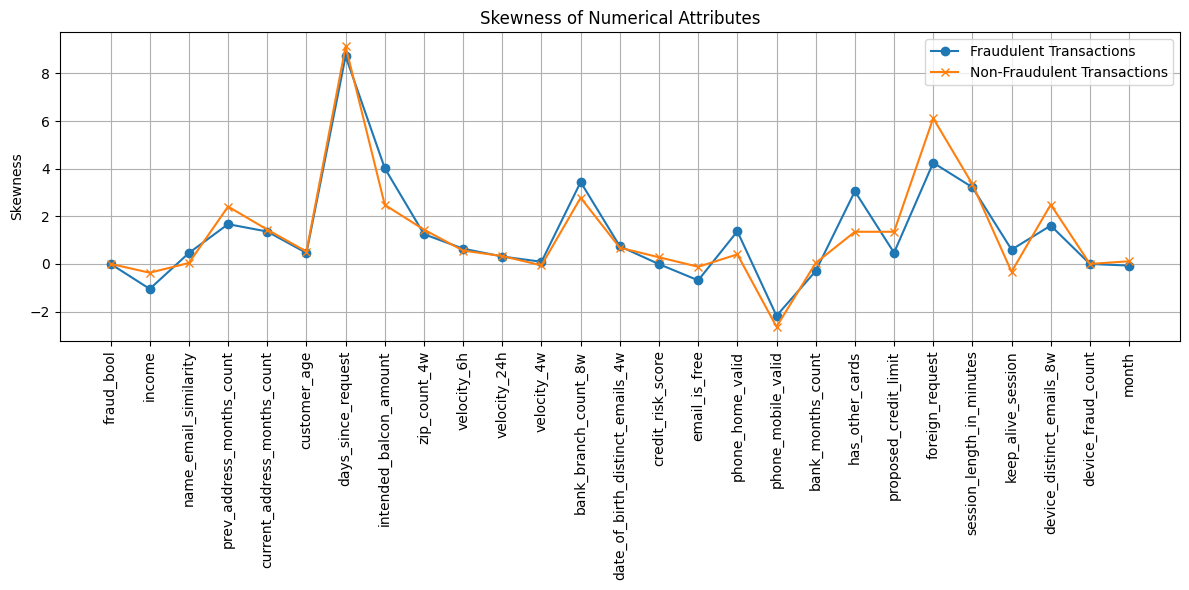

In [90]:
skew_fraud = fraud.select_dtypes(exclude='object').skew().round(2)
skew_non_fraud = non_fraud.select_dtypes(exclude='object').skew().round(2)

plt.figure(figsize=(12, 6))
plt.plot(skew_fraud, label='Fraudulent Transactions', marker='o')
plt.plot(skew_non_fraud, label='Non-Fraudulent Transactions', marker='x')
plt.xticks(rotation=90)
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Attributes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


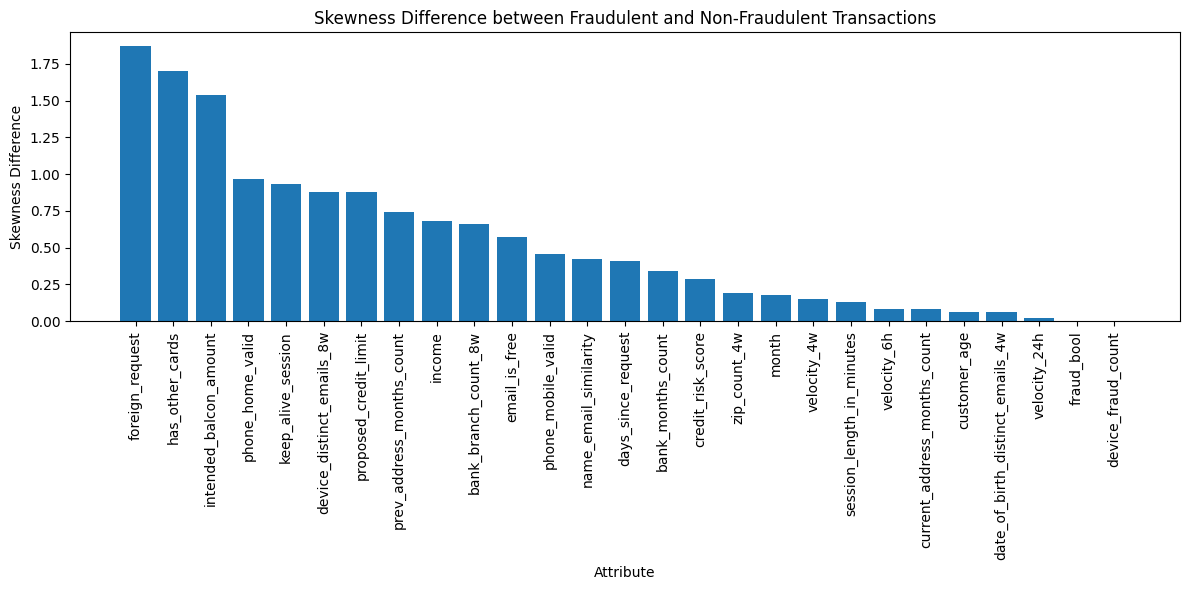

In [91]:
skew_delta = (skew_fraud - skew_non_fraud).abs().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(skew_delta.index, skew_delta)
plt.xticks(rotation=90)
plt.xlabel('Attribute')
plt.ylabel('Skewness Difference')
plt.title('Skewness Difference between Fraudulent and Non-Fraudulent Transactions')
plt.tight_layout()
plt.show()

In [92]:
non_fraud.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,988971.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
income,988971.0,0.559486,0.290339,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,988971.0,0.495667,0.288597,5.024707e-08,0.228388,0.493536,0.756474,1.000000
prev_address_months_count,294557.0,59.670254,62.444950,6.000000e+00,25.000000,34.000000,65.000000,399.000000
current_address_months_count,984540.0,83.755073,86.528424,0.000000e+00,18.000000,50.000000,124.000000,429.000000
customer_age,988971.0,31.941361,10.898518,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,988971.0,1.050389,5.453372,1.373749e-08,0.007167,0.015132,0.026216,76.635022
intended_balcon_amount,988971.0,8.766714,20.242427,-1.573989e+01,-1.180103,-0.827155,6.852145,113.120051
zip_count_4w,988971.0,1573.771820,1003.745865,1.000000e+00,893.000000,1269.000000,1950.000000,6678.000000
velocity_6h,988971.0,5667.936491,3011.318180,-1.741097e+02,3437.688484,5305.957557,7697.917455,16817.838935


In [93]:
fraud.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,11029.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
income,11029.0,0.684731,0.267155,0.100000,0.500000,0.800000,0.900000,0.900000
name_email_similarity,11029.0,0.403582,0.296689,0.000091,0.138665,0.310368,0.682687,0.999986
prev_address_months_count,1076.0,81.966543,80.575851,8.000000,28.000000,52.500000,104.000000,357.000000
current_address_months_count,11018.0,102.524415,78.480775,0.000000,48.000000,81.000000,138.000000,391.000000
customer_age,11029.0,34.918850,10.360970,10.000000,30.000000,40.000000,40.000000,80.000000
days_since_request,11029.0,1.171055,6.194905,0.000002,0.005769,0.012806,0.022968,75.535085
intended_balcon_amount,11029.0,4.085970,16.466915,-8.581278,-1.207180,-0.904116,-0.557577,110.475749
zip_count_4w,11029.0,1636.965999,997.687721,18.000000,924.000000,1371.000000,2079.000000,6401.000000
velocity_6h,11029.0,5121.945832,2920.454805,18.284813,2827.830744,4747.002505,7087.101610,16345.215780


The **mean** shows us that a large number of the records are non-fraudulent -> very high class imbalance thus some form of downsampling must take place for model training 

The **skewness** and **kurtosis** are very strong indicators of variables useful to use in fraud detection. These include (but not limited to): 
- **foreign request** - skewed strongly towards non-fraud (fraud transactions are more likely to be foreign requests)
- **device_distinct_email** - skewed towards fraud (more accounts per device)
- **has_other_cards** - skewed towards fraud (less likely to have more than one card)
- **current_address_months_count** - skewed towards non-fraud (fraudulent transactions are from addresses not stayed at for very long)
- **intended_balcon_amount** - skewed towards fraud (fraud transactions request more)

We can use log transformations on heavily skewed features in our model training to make them have a higher impact on the final result. We can compare and contrast our usage of this to ensure the most optimal result


#### Categorical Attributes

In [94]:
cat_attributes.describe().T

,count,unique,top,freq
payment_type,1000000,5,AB,364724
employment_status,1000000,7,CA,742492
housing_status,1000000,7,BC,380697
source,1000000,2,INTERNET,993214
device_os,1000000,5,other,352678


In [95]:
fraud = df[df['fraud_bool'] == 1].select_dtypes(include='object')
non_fraud = df[df['fraud_bool'] == 0].select_dtypes(include='object')

In [96]:
fraud.describe().T

,count,unique,top,freq
payment_type,11029,5,AC,4302
employment_status,11029,7,CA,9410
housing_status,11029,7,BA,5760
source,11029,2,INTERNET,10932
device_os,11029,5,windows,6061


In [97]:
fraud['device_os'].value_counts(normalize=True) 

device_os
windows      0.549551
other        0.198295
linux        0.162390
macintosh    0.081694
x11          0.008070
Name: proportion, dtype: float64

In [98]:
non_fraud.describe().T

,count,unique,top,freq
payment_type,988971,5,AB,360690
employment_status,988971,7,CA,733082
housing_status,988971,7,BC,377976
source,988971,2,INTERNET,982282
device_os,988971,5,other,350491


In [99]:
non_fraud['device_os'].value_counts(normalize=True)

device_os
other        0.354400
linux        0.331616
windows      0.252264
macintosh    0.054676
x11          0.007044
Name: proportion, dtype: float64

- Immediately the discrepancies between the device_os shows. Most fraud cases coming from windows devices whereas non_fraud cases are evenly distributed amongst devices
- Little to no variability in the categorical attributes meaning one-hot encoding will be our best option going forward

### Hypothesis

#### Data Analysis

Analysis of the data is difficult due to the large class imbalance (~0.2% of the transactions were fraud) but several different statistical measures give us a rough idea of the distribution of the data

- The average credit risk score of transactions were much higher for fraudulent transactions than non-fraudulent ones (160 vs 125)
- The velocity of payments were not skewed towards any direction and the averages were similar meaning several transactions were not carried out at once in this dataset and the use of bots can potentially be ruled out
    - Not a very good indicator of a fraudulent transaction 
- Foreign requests made up 8.5% of fraudulent transactions vs 3.5%. Not a great difference but results showed it to skew heavily towards fraudulent transactions and a high kurtosis value indicates that it could be very useful in determining if a transaction is fraudulent or not, the class imbalance may explain the small delta 
- 8% of fraud transactions came from accounts with other cards vs 18%. Skewed heavily towards fraud transactions
- Shorter address history in fraud cases, fraudsters may use new or temporary information 
- higher device distinct emails show that devices used for fraud are often reused or linked to multiple emails 
- Over half of fraud cases come from a Windows device 

#### Summary 
Credit risk score seems to be a strong indicator of whether a transaction is fraudulent or not. Bot activity can seemingly be ruled out given the small variance in velocities across classes. Fraudsters are more likely to be foreign, in possession of one card and using temporary addresses with the same email. They also seem to primarily come from windows devices and have missing information regarding the number of months they've been at the bank or at any previous address

### Feature Engineering

Based on the data analysis performed, feature engineering is applied to some of the strongest indicators of fraudulent behaviour for more robust training. We can then omit some of these features from the training model to assess their effectiveness. 

- **foreign_high_risk:** 1 if foreign_request == 1 and credit_risk_score > threshold & vice-versa 
- **multiple_cards_high_limit:** 1 if they have multiple cards & credit_limit about threshold

On top of this, we will be using one-hot-encoding to encode the categorical attributes and min-max scaling to ensure all the numerical values are given similar weighting. 

In [100]:
avg_credit_risk_score = df['credit_risk_score'].mean()
avg_credit_risk_score = df['credit_risk_score'].mean()


df['foreign_high_risk'] = [1 if (x == 1 and y > avg_credit_risk_score) else 0 for x, y in zip(df['foreign_request'], df['credit_risk_score'])]
df['multiple_cards_high_risk'] = [1 if (x == 1 and y < avg_credit_risk_score) else 0 for x, y in zip(df['has_other_cards'],df['credit_risk_score'])]

#### One-Hot Encoding

In [101]:
df['prev_address_months_count'] = pd.to_numeric(df['prev_address_months_count'], errors='coerce')
df['current_address_months_count'] = pd.to_numeric(df['current_address_months_count'], errors='coerce')
df['bank_months_count'] = pd.to_numeric(df['bank_months_count'], errors='coerce')

In [102]:
cat_attributes = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=cat_attributes, drop_first=True)

df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,foreign_high_risk,multiple_cards_high_risk,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.990415,11.0,4.0,40,0.014640,-0.897718,1853,6711.523027,4868.779488,4988.827961,0,19,113,1,0,1,NaN,0,200.0,0,6.150317,0,1,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1,0,0.4,0.781728,NaN,151.0,30,0.013269,11.501507,5447,8948.772349,5824.765506,6451.180606,16,14,83,1,0,1,5.0,0,1500.0,0,4.521952,1,1,0,0,0,0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,0,0.7,0.274290,NaN,92.0,20,0.010669,23.943928,2312,11727.292100,7679.867045,6731.304261,1351,15,70,0,1,1,28.0,0,200.0,0,8.361707,1,1,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,0,0.9,0.722684,NaN,55.0,20,0.021849,48.202774,2413,4126.145203,4458.366351,6356.833258,30,8,222,1,1,1,20.0,0,1500.0,0,7.339743,0,1,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
4,0,0.9,0.121661,NaN,51.0,20,0.021491,-1.602116,1227,9730.276231,5544.081678,6721.196241,505,12,126,1,0,1,1.0,0,1500.0,0,4.338063,0,1,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False


#### Min-Max Scaling

In [103]:
X = df.drop(columns=['fraud_bool'])
y = df['fraud_bool']

transformer = MinMaxScaler()
num_attributes = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer([('scaled', transformer, num_attributes)], remainder='passthrough')
X_transformed = preprocessor.fit_transform(X)

In [104]:
preprocessor_columns = preprocessor.get_feature_names_out()
preprocessor_columns = [x.replace('scaled__', '') for x in preprocessor_columns]
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_columns)   

X_transformed

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,foreign_high_risk,multiple_cards_high_risk,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,1.000,0.990415,0.012723,0.009324,0.375,0.000191,0.115181,0.277370,0.405229,0.431598,0.512403,0.000000,0.487179,0.525043,1.0,0.0,1.0,NaN,0.0,0.005236,0.0,0.082598,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.375,0.781728,NaN,0.351981,0.250,0.000173,0.211403,0.815636,0.536894,0.547940,0.863589,0.006706,0.358974,0.473230,1.0,0.0,1.0,0.129032,0.0,0.685864,0.0,0.063788,1.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.750,0.274290,NaN,0.214452,0.125,0.000139,0.307961,0.346114,0.700414,0.773703,0.930861,0.566220,0.384615,0.450777,0.0,1.0,1.0,0.870968,0.0,0.005236,0.0,0.108143,1.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.000,0.722684,NaN,0.128205,0.125,0.000285,0.496218,0.361240,0.253076,0.381651,0.840931,0.012573,0.205128,0.713299,1.0,1.0,1.0,0.612903,0.0,0.685864,0.0,0.096338,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.000,0.121661,NaN,0.118881,0.125,0.000280,0.109714,0.183615,0.582887,0.513781,0.928434,0.211651,0.307692,0.547496,1.0,0.0,1.0,0.000000,0.0,0.685864,0.0,0.061663,0.0,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.000,0.173671,NaN,0.256410,0.250,0.000053,0.110879,0.146473,0.086176,0.266197,0.201982,0.002515,0.128205,0.704663,1.0,1.0,1.0,0.774194,0.0,0.005236,0.0,0.077862,1.0,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
999996,1.000,0.566285,NaN,0.067599,0.500,0.000185,0.116925,0.178074,0.083516,0.140420,0.067533,0.005868,0.076923,0.696028,0.0,0.0,1.0,0.000000,0.0,0.005236,0.0,0.315582,0.0,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999997,0.625,0.807476,NaN,0.382284,0.250,0.000524,0.480127,0.235136,0.272311,0.257904,0.036995,0.006706,0.102564,0.649396,0.0,1.0,1.0,0.774194,0.0,0.424084,0.0,0.030201,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999998,0.875,0.151376,0.206107,0.027972,0.250,0.000220,0.112741,0.214767,0.186170,0.185435,0.035766,0.000419,0.256410,0.575130,0.0,1.0,1.0,NaN,0.0,0.005236,0.0,0.054092,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

#### Resampling
Privy to the data analysis done prior, fraud cases take up 1% of the training data. This is not enough minority class examples to train a model properly as it can't learn enough about the fraud cases relative to the non-fraud counterparts which may result in several false-negative cases. Consequently, we must resample the dataset to adjust for this class imbalance. There are three ways of doing this

- **Undersampling:** Training the model on a reduced number of majority class samples so the class ratio is more balanced. Risks losing some important information for training
- **Oversampling:** Increasing the number of minority class samples, either by duplicating existing cases or generating synthetic ones. Risks overfitting
- **Upweighting:** Keep the dataset intact but assign a higher misclassification penalty to the minority class during training

While undersampling risks losing information, in our instance, the majority class is overwhelmingly large with the dataset containing 1000000 records, so there is enough data to risk losing some non-fraud cases without significantly harming model performance

In [105]:
from numpy import where
from matplotlib import pyplot

In [108]:
# Use NearMiss Sampling
counter = Counter(y)
print(f"Original dataset shape: {counter}")
# Temporarily convert nan values to a constant for resampling
X_transformed.fillna(-1, inplace=True)

undersample = NearMiss(version=3, n_neighbors=3)
X_nm, y_nm = undersample.fit_resample(X_transformed, y)

counter = Counter(y_nm)
print(f"Resampled dataset shape: {counter}")

X_nm.replace(-1, np.nan, inplace=True)  # Convert back to NaN
X_nm.head()

Original dataset shape: Counter({0: 988971, 1: 11029})
Resampled dataset shape: Counter({0: 11029, 1: 11029})


,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,foreign_high_risk,multiple_cards_high_risk,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.750,0.123806,0.012723,0.011655,0.375,0.000154,0.112983,0.133743,0.330305,0.665991,0.730000,0.002515,0.333333,0.616580,0.0,0.0,1.0,0.83871,0.0,0.005236,1.0,0.042494,0.0,0.666667,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.875,0.990661,0.358779,0.510490,0.125,0.000030,0.119748,0.496780,0.108534,0.755086,0.591945,0.000419,0.153846,0.440415,1.0,1.0,0.0,NaN,1.0,0.005236,0.0,0.075207,0.0,0.666667,0.0,0.142857,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000,0.788728,0.117048,0.011655,0.125,0.000066,0.505484,0.252658,0.616401,0.626091,0.641839,0.002934,0.256410,0.763385,1.0,1.0,0.0,0.00000,1.0,0.685864,0.0,0.103325,0.0,0.666667,0.0,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.875,0.175962,0.183206,0.048951,0.125,0.000212,0.116161,0.149468,0.353132,0.499093,0.471293,0.000419,0.256410,0.542314,1.0,0.0,0.0,NaN,1.0,0.005236,0.0,0.077763,0.0,0.333333,0.0,0.571429,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000,0.510042,0.012723,0.025641,0.125,0.000094,0.115410,0.097499,0.462850,0.268823,0.323649,0.002934,0.282051,0.606218,0.0,0.0,1.0,0.16129,0.0,0.162304,1.0,0.074338,1.0,0.666667,0.0,0.857143,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Using near miss undersampling helps select the non-fraud cases that are the closest in distance to each fraud case example allowing us to select the non-fraud cases on the boundary line which ensures the model learns from the most challenging examples

We can use variance thresholding to ensure that the features remaining have a high variance which removes redundant columns that won't offer much in the training cycle

In [112]:
selector = VarianceThreshold()
selector.fit_transform(X_nm)
redundant_features = [feature for feature in X_nm.columns if feature not in X_nm.columns[selector.get_support()]]

print(f"Redundant features removed: {redundant_features}")
X_nm.drop(columns=redundant_features, inplace=True)
X_nm.head()
# X_nm_reduced = pd.DataFrame(X_nm_reduced, columns=selected_features)

Redundant features removed: ['device_fraud_count']


,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,foreign_high_risk,multiple_cards_high_risk,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.750,0.123806,0.012723,0.011655,0.375,0.000154,0.112983,0.133743,0.330305,0.665991,0.730000,0.002515,0.333333,0.616580,0.0,0.0,1.0,0.83871,0.0,0.005236,1.0,0.042494,0.0,0.666667,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.875,0.990661,0.358779,0.510490,0.125,0.000030,0.119748,0.496780,0.108534,0.755086,0.591945,0.000419,0.153846,0.440415,1.0,1.0,0.0,NaN,1.0,0.005236,0.0,0.075207,0.0,0.666667,0.142857,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000,0.788728,0.117048,0.011655,0.125,0.000066,0.505484,0.252658,0.616401,0.626091,0.641839,0.002934,0.256410,0.763385,1.0,1.0,0.0,0.00000,1.0,0.685864,0.0,0.103325,0.0,0.666667,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.875,0.175962,0.183206,0.048951,0.125,0.000212,0.116161,0.149468,0.353132,0.499093,0.471293,0.000419,0.256410,0.542314,1.0,0.0,0.0,NaN,1.0,0.005236,0.0,0.077763,0.0,0.333333,0.571429,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000,0.510042,0.012723,0.025641,0.125,0.000094,0.115410,0.097499,0.462850,0.268823,0.323649,0.002934,0.282051,0.606218,0.0,0.0,1.0,0.16129,0.0,0.162304,1.0,0.074338,1.0,0.666667,0.857143,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [139]:
num_attributes = X_nm.select_dtypes(exclude='object').columns.tolist()
cat_attributes = X_nm.select_dtypes(include='object').columns.tolist()

# Calculate correlation matrix for numerical features
corr_matrix = X_nm[num_attributes].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,foreign_high_risk,multiple_cards_high_risk,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
income,1.000000,-0.033955,0.049661,-0.017639,0.088750,-0.001333,0.012380,-0.071343,-0.094860,-0.095662,-0.103758,-0.005531,-0.038720,0.201043,-0.009017,-0.018991,0.040935,-0.021671,0.043022,0.153673,0.007670,-0.045627,-0.045536,-0.018600,0.116019,0.033709,-0.027351,-0.040691,0.001873,0.060018,0.001102,0.050664,-0.050075,-0.076936,-0.050467,-0.045080,-0.015829,-0.084673,-0.012149,-0.009989,-0.133657,-0.006116,-0.011464,-0.005483,0.039993,-0.026327,0.038886,0.010458
name_email_similarity,-0.033955,1.000000,-0.018442,0.040049,-0.021581,-0.015998,0.038857,0.017978,0.020374,0.043743,0.053165,0.017579,0.009320,0.074786,-0.059154,0.020110,-0.012348,-0.013025,0.025554,0.092165,-0.001269,0.017898,0.030744,-0.024872,-0.054530,0.010464,0.003038,-0.063347,0.021175,0.016246,-0.006422,-0.041066,-0.029438,-0.014795,0.035824,-0.005905,-0.011936,0.008462,-0.032765,0.013997,0.057336,0.008559,-0.002420,-0.009018,-0.002234,-0.004158,0.043718,0.010382
prev_address_months_count,0.049661,-0.018442,1.000000,0.094311,0.088018,0.038067,0.002671,-0.017674,-0.009857,-0.030022,-0.034037,0.003100,-0.097210,0.053067,-0.014805,0.001253,-0.035717,0.029295,-0.075561,0.021020,-0.054087,0.001432,0.011347,0.032977,0.036603,-0.035586,-0.046567,-0.056649,0.096703,-0.065956,nan,0.017826,0.039369,-0.018305,0.026403,-0.025265,-0.008555,0.053278,-0.149106,-0.041874,0.017023,-0.013569,0.035835,0.030345,-0.062217,0.050064,0.044092,0.004752
current_address_months_count,-0.017639,0.040049,0.094311,1.000000,0.172154,-0.046062,0.036785,0.023384,0.018799,0.018838,0.026871,0.029888,-0.187873,0.110853,-0.080650,0.097609,-0.081651,0.049096,0.036079,0.115015,-0.025395,-0.009709,-0.041084,-0.007761,-0.023052,-0.006212,-0.011153,-0.013691,-0.003649,-0.026782,-0.001954,0.033478,0.120222,-0.025985,0.012945,-0.021521,0.000628,-0.047867,-0.302081,-0.054535,0.118399,-0.002969,0.006215,0.009121,-0.012936,0.003922,0.029311,-0.020681
customer_age,0.088750,-0.021581,0.088018,0.172154,1.000000,-0.032935,-0.033257,-0.021504,-0.028628,-0.015580,-0.026475,0.003299,-0.420667,0.186104,-0.025406,0.162850,-0.111430,-0.002973,0.050660,0.155082,-0.020216,0.029209,-0.037042,0.022583,0.030444,-0.003362,-0.009659,0.060404,0.028002,-0.064490,-0.009178,-0.002627,0.329094,-0.016718,-0.078663,-0.002864,-0.007982,0.034558,-0.091903,-0.023532,-0.287158,-0.022023,-0.002837,0.017112,-0.050081,-0.085442,0.096075,0.008083
days_since_request,-0.001333,-0.015998,0.038067,-0.046062,-0.032935,1.000000,0.011839,0.004877,0.030623,0.019657,0.008549,-0.026203,0.020027,-0.081264,0.007534,-0.025204,0.018301,0.040884,-0.039984,-0.063846,-0.014591,0.040302,0.005738,0.025892,-0.014975,-0.023814,-0.009349,-0.091646,0.105191,-0.048489,-0.001194,-0.015187,-0.018867,0.019046,-0.000177,0.000954,-0.003073,-0.011623,0.041189,0.012638,0.002754,0.008009,0.012645,0.018779,-0.013168,0.011428,-0.008774,0.010151
intended_balcon_amount,0.012380,0.038857,0.002671,0.036785,-0.033257,0.011839,1.000000,0.023944,0.050055,0.083178,0.103363,0.064804,0.005734,-0.047879,-0.010335,0.017920,0.064400,-0.008004,0.072660,-0.003724,0.010283,0.026512,0.008854,-0.037557,-0.095568,0.006826

The features don't exhibit much linearity between them with the most correlation deriving from engineered features created from each other (which was to be expected). Thus multicolinearity is (thankfully) ruled out which would have made it difficult to determine the individual effect of each independent variable on the dependent variable being fraud_bool